In [ ]:
import pandas as pd
import numpy as np
from functools import reduce
from scipy.special import expit
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import defaultdict
from math import log
from tqdm import tqdm
import psutil

In [ ]:
# Cargar embeddings de canciones y usuarios
song_embeddings = pd.read_parquet('dataset/song_embeddings.parquet')
user_embeddings = pd.read_parquet('dataset/user_embeddings.parquet')

# Cargar datos de entrenamiento y validación (usando el espacio TT-SVD como ejemplo)
train_data_svd = pd.read_parquet('/content/dataset/user_features_train_svd.parquet')

In [ ]:
from sklearn.cluster import KMeans
import ast

# Número de clusters
num_clusters = 15

# Crear el modelo de clustering k-means y entrenarlo
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
user_clusters = kmeans.fit_predict(np.stack(user_embeddings['svd_embeddings'].apply(lambda x: ast.literal_eval(x.decode()))))

# Agregar los clusters como columna en el DataFrame de usuarios
user_embeddings['cluster'] = user_clusters
user_history_songs = train_data_svd["d1d30_songs"]

In [ ]:
train_data_svd["d1d30_songs"]

,d1d30_songs
0,"[5718, 32987, 21596, 49224, 19571, 3492, 31893..."
1,"[4611, 1279, 44628, 61, 24237, 3882, 19, 1858,..."
2,"[38887, 608, 8143, 474, 428, 37824, 34873, 210..."
3,"[4611, 4819, 747, 39099, 17332, 28040, 11382, ..."
4,"[12821, 7795, 3312, 178, 17779, 384, 14399, 60..."
...,...
69995,"[920, 11129, 15160, 28263, 8257, 46380, 6652, ..."
69996,"[32761, 15667, 4677, 19589, 34634, 22925, 8708..."
69997,"[3644, 22925, 373, 6954, 548, 371, 2496, 2001,..."
69998,"[8816, 20460, 27970, 5601, 6220, 10799, 884, 7..."


In [ ]:
num_playlists = 100

kmeans = KMeans(n_clusters=num_playlists, random_state=0)

# Check if the 'features_svd' column contains strings or arrays:
if isinstance(song_embeddings['features_svd'].iloc[0], str):
    # If strings, decode and evaluate using ast.literal_eval
    playlist_clusters = kmeans.fit_predict(np.stack(song_embeddings['features_svd'].apply(lambda x: ast.literal_eval(x.decode()))))
else:
    # If already arrays, directly stack them
    playlist_clusters = kmeans.fit_predict(np.stack(song_embeddings['features_svd'].values))

song_embeddings["cluster"] = playlist_clusters

In [ ]:
user_history_playlists = []
for user_songs in tqdm(user_history_songs):
    # Usamos un set para el historial del usuario, lo que elimina la necesidad de comprobar duplicados
    user_history = set()

    # Convertimos user_songs en un set para búsqueda eficiente
    user_songs_set = set(user_songs)

    for j, song_cluster in enumerate(song_embeddings["cluster"]):
        if song_cluster in user_songs_set:
            user_history.add(song_cluster)  # Usamos el set para evitar duplicados automáticamente

    # Al final, convertimos el set en lista si es necesario
    user_history_playlists.append(list(user_history))

100%|██████████| 70000/70000 [14:56<00:00, 78.06it/s]


In [ ]:
def get_songs_in_playlist(playlist_id):
    return song_embeddings[song_embeddings['cluster'] == playlist_id]

In [ ]:
# Crear una lista para almacenar las playlists como filas
playlist_vectors = []

for cluster_id in range(num_playlists):
    # Filtrar las canciones que pertenecen al clúster actual
    cluster_songs = song_embeddings[song_embeddings['cluster'] == cluster_id]

    # Calcular el promedio de los embeddings en el clúster
    cluster_vector = np.mean(np.stack(cluster_songs['features_svd'].values), axis=0)

    # Agregar el vector a la lista
    playlist_vectors.append(cluster_vector)

# Convertir la lista de vectores en un DataFrame
playlist_svd_cluster = pd.DataFrame(playlist_vectors)

# Renombrar las columnas como dimensiones
playlist_svd_cluster.columns = [f'dim_{i}' for i in range(playlist_svd_cluster.shape[1])]

playlist_svd_cluster

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_118,dim_119,dim_120,dim_121,dim_122,dim_123,dim_124,dim_125,dim_126,dim_127
0,-0.001288,0.007457,-0.000591,-0.008287,0.007185,0.020087,-0.004523,0.016524,-0.005538,-0.001352,...,0.064627,-0.100894,0.131037,0.034217,0.166111,0.030373,0.018486,-0.056094,0.016981,-0.029349
1,0.003111,0.000642,0.000184,0.010633,0.002798,-0.002042,0.001939,-0.002628,0.008318,-0.019770,...,0.021025,0.023586,-0.000071,-0.017372,0.076777,-0.023887,0.047665,-0.005897,0.062355,-0.047915
2,0.000671,0.000020,-0.004093,0.009548,-0.007435,-0.002711,0.007385,0.008068,-0.001744,-0.008284,...,0.031460,0.073784,0.149405,-0.013374,0.025109,-0.003638,-0.043867,0.025243,-0.015844,-0.019599
3,0.001665,-0.004759,0.003724,0.003201,0.000702,-0.207377,0.004678,0.006043,-0.000107,-0.342586,...,0.016058,-0.005281,0.020433,-0.005082,-0.062093,-0.006888,-0.008808,-0.047891,0.042943,0.013123
4,-0.001144,0.003243,-0.009829,0.006728,0.022498,0.006801,0.014593,-0.007906,-0.012373,-0.002429,...,0.052982,0.018881,-0.008927,0.066456,-0.013672,-0.055365,0.038590,-0.102499,-0.118035,0.119439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.001149,0.000712,-0.001574,-0.004924,0.002453,-0.007389,0.012309,0.003182,0.015905,-0.004194,...,0.016578,-0.001104,0.006196,0.007030,0.008225,-0.000212,0.006115,-0.002651,-0.002467,0.009520
96,-0.000690,0.002141,-0.018666,-0.017103,-0.002234,-0.006127,0.020137,0.032394,0.032244,-0.045490,...,0.125068,-0.013070,0.101970,0.013951,0.165411,-0.054084,0.074849,-0.017860,-0.008592,-0.060068
97,-0.001572,0.000742,-0.007535,0.004137,0.014794,0.000806,0.008441,-0.002462,0.016357,-0.008259,...,-0.043129,0.008891,-0.136601,-0.077918,0.050188,-0.084707,-0.000563,0.018612,-0.064194,-0.089655
98,0.001277,-0.000477,-0.003432,-0.000872,-0.000858,0.000396,0.040157,0.013898,0.018315,-0.012345,...,0.020944,-0.007103,-0.009620,0.019022,0.020938,0.009078,-0.049415,0.019541,0.004497,-0.026619


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Assuming user_features is your DataFrame (train_data_svd)
# Select only the numerical features, excluding columns with lists or sequences
user_features = train_data_svd
numerical_feature_columns = [col for col in user_features.columns if col != 'd1d30_songs' and col != 'user_index']
user_features_numerical = user_features[numerical_feature_columns]

# Impute NaN values using the mean of each column
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'
user_features_imputed = imputer.fit_transform(user_features_numerical)

# Preprocessing: Standardize the numerical features
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features_imputed)

# Apply PCA
pca = PCA(n_components=128)
user_features_reduced = pca.fit_transform(user_features_scaled)
user_features_svd = user_features_reduced

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

class ContextualEnvironment():
    def __init__(self, user_features, playlist_features, user_segment, n_recos):
        self.user_features = user_features
        self.playlist_features = playlist_features
        self.user_segment = user_segment
        self.n_recos = n_recos
        self.th_segment_rewards = np.zeros(user_features.shape[0])
        self.th_rewards = np.zeros(user_features.shape[0])
        self.compute_optimal_theoretical_rewards()
        self.compute_segment_optimal_theoretical_rewards()
        self.user_history = {user_id: set() for user_id in range(user_features.shape[0])}
        self.relevant_playlists = {user_id: set(np.random.choice(range(self.playlist_features.shape[0]), 10)) for user_id in range(user_features.shape[0])}

    # Computes expected reward for each user given their recommendations
    def compute_theoretical_rewards(self, batch_user_ids, batch_recos):
        batch_user_features = np.take(self.user_features, batch_user_ids, axis = 0)
        batch_playlist_features = np.take(self.playlist_features, batch_recos, axis = 0)
        n_users = len(batch_user_ids)
        th_reward = np.zeros(n_users)
        for i in range(n_users):
            probas = expit(batch_user_features[i].dot(batch_playlist_features[i].T))
            th_reward[i] = 1 - reduce(lambda x,y : x * y, 1 - probas)
        return th_reward

    # Computes list of n recommendations with highest expected reward for each user
    def compute_optimal_recos(self, batch_user_ids, n):
        batch_user_features = np.take(self.user_features, batch_user_ids, axis = 0)
        n_users = len(batch_user_ids)
        probas = batch_user_features.dot(self.playlist_features.T)
        optim = np.argsort(-probas)[:, :n]
        return optim

    # Computes highest expected reward for each user
    def compute_optimal_theoretical_rewards(self):
        n_users = self.user_features.shape[0]
        u = 0
        step = 100000
        while u < n_users:
            users_ids = range(u, min(n_users, u + step))
            opt_recos = self.compute_optimal_recos(users_ids, self.n_recos)
            opt_rewards = self.compute_theoretical_rewards(users_ids, opt_recos)
            self.th_rewards[u:min(n_users, u + step)] = opt_rewards
            u += step
        return

    # Computes list of n recommendations with highest expected reward for each segment
    def compute_segment_optimal_recos(self, n):
        n_segments = len(np.unique(self.user_segment))
        segment_recos = np.zeros((n_segments, n), dtype = np.int64)
        for i in range(n_segments):
            mean_probas = np.mean(expit(np.take(self.user_features, np.where(self.user_segment == i)[0], axis = 0).dot(self.playlist_features.T)), axis = 0)
            reward = 1 - reduce(lambda x,y : x * y, 1 + np.sort(-mean_probas)[:n])
            segment_recos[i] = np.argsort(-mean_probas)[:n]
        return segment_recos

    # Computes highest expected reward for each segment
    def compute_segment_optimal_theoretical_rewards(self):
        n_users = self.user_features.shape[0]
        u = 0
        step = 100000
        segment_recos = self.compute_segment_optimal_recos(self.n_recos)
        while u < n_users:
            users_ids = range(u, min(n_users, u+ step))
            user_segment = np.take(self.user_segment, users_ids)
            opt_recos = np.take(segment_recos, user_segment, axis = 0)
            opt_rewards = self.compute_theoretical_rewards(users_ids, opt_recos)
            self.th_segment_rewards[u:min(n_users, u+ step)] = opt_rewards
            u += step
        return

    # Given a list of users and their respective list of recos (each of size self.n_recos), computes
    # corresponding simulated reward
    def simulate_batch_users_reward(self, batch_user_ids, batch_recos):
        # Primero, computamos la probabilidad de que cada recomendación sea aceptada
        batch_user_features = np.take(self.user_features, batch_user_ids, axis=0)
        batch_playlist_features = np.take(self.playlist_features, batch_recos, axis=0)
        n_users = len(batch_user_ids)
        n = len(batch_recos[0])  # Asumiendo que cada usuario tiene el mismo número de recomendaciones
        probas = np.zeros((n_users, n))

        # Calculando la probabilidad de que el usuario reproduzca cada recomendación
        for i in range(n_users):
            probas[i] = expit(batch_user_features[i].dot(batch_playlist_features[i].T))  # Sigmoide

        rewards = np.zeros((n_users, n))
        rewards_uncascaded = np.random.binomial(1, probas)  # Dibujando las recompensas de acuerdo a las probabilidades
        positive_rewards = set()  # Para asegurar que solo se asigna un premio positivo por usuario

        # Cascada de recompensas: solo el primer "stream" cuenta
        nz = rewards_uncascaded.nonzero()
        for i in range(len(nz[0])):
            if nz[0][i] not in positive_rewards:
                rewards[nz[0][i]][nz[1][i]] = 1
                positive_rewards.add(nz[0][i])

        # Actualización del historial para cada usuario
        for user_id, recos in zip(batch_user_ids, batch_recos):
            self.user_history[user_id].update(recos)  # Asegúrate de que recos sean IDs de playlists

        return rewards

    def compute_diversity(self, batch_recos):
        """
        Calcula la diversidad de las recomendaciones basándose en la similitud de los embeddings de las playlists.
        """
        n_users = len(batch_recos)
        diversities = np.zeros(n_users)
        for i in range(n_users):
            reco_features = np.take(self.playlist_features, batch_recos[i], axis=0)
            pairwise_similarities = cosine_similarity(reco_features)
            # Diversidad como 1 - promedio de las similitudes (para que valores más altos signifiquen más diversidad)
            diversities[i] = 1 - np.mean(pairwise_similarities[np.triu_indices(len(reco_features), k=1)])
        return diversities

    # Agrega un método para calcular la novedad:
    def compute_novelty(self, batch_recos, batch_user_ids, user_history):
        novelties = np.zeros(len(batch_user_ids))

        for i, user_id in enumerate(batch_user_ids):
            # Asegúrate de que el historial del usuario es un conjunto
            # seen_playlists = set(self.user_history.get(user_id, []))
            seen_playlists = set(user_history[user_id])

            # Asegúrate de que las recomendaciones son un conjunto
            recommended_playlists = set(batch_recos[i])

            if len(recommended_playlists) > 0:
                # Calcular la novedad como la proporción de ítems nuevos
                novelty_score = len(recommended_playlists - seen_playlists) / len(recommended_playlists)
            else:
                # Si no hay recomendaciones, la novedad es 0
                novelty_score = 0

            novelties[i] = novelty_score

        return novelties


    def compute_mrr(self, batch_recos, batch_user_ids):
        """
        Calcula el MRR basándose en la posición del primer ítem relevante en las recomendaciones.
        """
        mrr_scores = np.zeros(len(batch_user_ids))
        for i, user_id in enumerate(batch_user_ids):
            relevant_playlists = self.relevant_playlists[user_id]
            for rank, reco in enumerate(batch_recos[i]):
                if reco in relevant_playlists:
                    mrr_scores[i] = 1 / (rank + 1)
                    break
        return mrr_scores

    def compute_ndcg(self, batch_recos, batch_user_ids, k=10):

        """
        Calcula el NDCG para un conjunto de usuarios y recomendaciones.
        """
        ndcg_scores = np.zeros(len(batch_user_ids))
        for i, user_id in enumerate(batch_user_ids):
            relevant_playlists = self.relevant_playlists[user_id]
            gains = [1 if reco in relevant_playlists else 0 for reco in batch_recos[i][:k]]
            dcg = sum([g / np.log2(idx + 2) for idx, g in enumerate(gains)])  # DCG
            idcg = sum([1 / np.log2(idx + 2) for idx in range(min(len(relevant_playlists), k))])  # Ideal DCG
            ndcg_scores[i] = dcg / idcg if idcg > 0 else 0
        return ndcg_scores

In [ ]:
from scipy.optimize import minimize
import numpy as np


# Disclaimer: this class is taken from:
# https://gdmarmerola.github.io/ts-for-contextual-bandits/


# Defining a class for Online Bayesian Logistic Regression
class OnlineLogisticRegression:

    # Initializing
    def __init__(self, lambda_, alpha, n_dim, bias, maxiter = 15):

        # Hyperparameter: deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_; self.alpha = alpha; self.maxiter = maxiter

        # Initializing parameters of the model
        self.n_dim = n_dim
        # m: mean of the Bi, q inverse variance of the distribution
        self.m = np.zeros(self.n_dim)
        self.m[-1] = bias
        self.q = np.ones(self.n_dim) * self.lambda_

        # Initializing weights
        self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)

    # Loss function
    def loss(self, w, *args):
        X, y = args
        # Note: the bias is removed from the "regularization term" of the loss
        return 0.5 * (self.q[:-1] * (w[:-1] - self.m[:-1])).dot(w[:-1] - self.m[:-1]) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])

    # Gradient
    def grad(self, w, *args):
        X, y = args
        return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)

    # Fitting method
    def fit(self, X, y):

        # Step 1, find w
        self.w = minimize(self.loss, self.w, args = (X, y), jac = self.grad, method = "L-BFGS-B", options = {'maxiter': self.maxiter}).x
        self.m = self.w

        # Step 2, update q
        P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
        self.q = self.q + (P*(1-P)).dot(X ** 2)

In [ ]:
# Abstract class defining the minimal functions that need
# to be implemented to create new bandit policy classes

class Policy:

    # Returns a list of size n_recos of playlist ids
    def recommend_to_users_batch(self, batch_users, n_recos=12):
        return

    # Updates policies parameters
    def update_policy(self, user_ids, recos , rewards):
        return


# A simple baseline that randomly recommends n_recos playlists to each user.
class RandomPolicy(Policy):
    def __init__(self, n_playlists, cascade_model=True):
        self.cascade_model = cascade_model
        self.n_playlists = n_playlists

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        n_users = len(batch_users)
        recos = np.zeros((n_users, n_recos), dtype=np.int64)
        r = np.arange(self.n_playlists)
        for i in range(n_users):
            np.random.shuffle(r)
            recos[i] = r[:n_recos]
        return recos

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        return


#  Upper Confidence Bound (UCB) strategy, using KL-UCB bounds [Garivier and Cappe, 2011] tailored for Bernoulli rewards
class KLUCBSegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, precision = 1e-6, eps = 1e-15, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.playlist_score = np.ones((n_segments, n_playlists))
        self.t = 0
        self.cascade_model = cascade_model
        self.precision = precision
        self.eps = eps

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_score = np.take(self.playlist_score, user_segment, axis = 0)
        # Break ties
        user_random_score = np.random.random(user_score.shape)
        user_choice = np.lexsort((user_random_score, -user_score))[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def kl(self, x, y):
        x = min(max(x, self.eps), 1 - self.eps)
        y = min(max(y, self.eps), 1 - self.eps)
        return x * log(x / y) + (1 - x) * log((1 - x) / (1 - y))

    def scoring_function(self, n_success, n, t):
        if n == 0:
            return 1.0
        p = n_success / n
        value = p
        u = 1
        threshold = log(t) / n
        _count_iteration = 0
        while _count_iteration < 50 and u - value > self.precision:
            _count_iteration += 1
            m = (value + u) * 0.5
            if self.kl(p, m) > threshold:
                u = m
            else:
                value = m
        return (value + u) * 0.5

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        batch_size = len(user_ids)
        modified_data = defaultdict(set)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                modified_data[user_segment].add(p)
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        self.t = self.playlist_display.sum()
        for seg,pls in modified_data.items():
            for pl in pls:
                self.playlist_score[seg][pl] = self.scoring_function(self.playlist_success[seg][pl], self.playlist_display[seg][pl], self.t)
        return


# An Explore-then-Commit strategy: similar to random until each playlist has been displayed n times or more,
# then recommends the top n_reco playlists with highest mean observed rewards, for each segment
class ExploreThenCommitSegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, min_n, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.min_n = min_n
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_success = np.take(self.playlist_success, user_segment, axis = 0)
        user_displays = np.take(self.playlist_display, user_segment, axis = 0).astype(float)
        user_random_score = np.random.random(user_displays.shape)
        user_score = np.divide(user_success, user_displays, out=np.zeros_like(user_displays), where=user_displays!=0)
        discounted_displays = np.maximum(np.zeros_like(user_displays), self.min_n - user_displays)
        user_choice = np.lexsort((user_random_score, - user_score, -discounted_displays))[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def update_policy(self, user_ids, recos , rewards, l_init=3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return


# Segment-based Epsilon-Greedy strategy: recommends playlists randomly with probability epsilon,
# otherwise recommends the top n_recos with highest mean observed rewards.
class EpsilonGreedySegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, epsilon, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.playlist_score = np.ones((n_segments, n_playlists))
        self.epsilon = epsilon
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_scores = np.take(self.playlist_score, user_segment, axis = 0)
        user_random_score = np.random.random(user_scores.shape)
        n_users = len(batch_users)
        user_greedy = np.random.binomial(1, [1- self.epsilon for i in range(n_users)])
        new_scores = user_scores * user_greedy[:,np.newaxis]
        user_choice = np.lexsort((user_random_score, -new_scores))[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                self.playlist_score[user_segment][p] = self.playlist_success[user_segment][p] / self.playlist_display[user_segment][p]
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return


# Segment-based Thompson Sampling strategy, with Beta(alpha_zero,beta_zero) priors
class TSSegmentPolicy(Policy):
    def __init__(self, user_segment, n_playlists, alpha_zero=1, beta_zero=99, cascade_model=True):
        self.user_segment = user_segment
        n_segments = len(np.unique(self.user_segment))
        self.playlist_display = np.zeros((n_segments, n_playlists))
        self.playlist_success = np.zeros((n_segments, n_playlists))
        self.alpha_zero = alpha_zero
        self.beta_zero = beta_zero
        self.t = 0
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_segment = np.take(self.user_segment, batch_users)
        user_displays = np.take(self.playlist_display, user_segment, axis = 0).astype(float)
        user_success = np.take(self.playlist_success, user_segment, axis = 0)
        user_score = np.random.beta(self.alpha_zero+user_success, self.beta_zero+user_displays - user_success)
        user_choice = np.argsort(-user_score)[:, :n_recos]
        # Shuffle l_init first slots
        np.random.shuffle(user_choice[0:l_init])
        return user_choice

    def update_policy(self, user_ids, recos , rewards, l_init = 3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            user_segment = self.user_segment[user_ids[i]]
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                self.playlist_success[user_segment][p]+=r
                self.playlist_display[user_segment][p]+=1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return


# Linear Thompson Sampling strategy for fully personalized contextual bandits, as in [Chapelle and Li, 2011]
class LinearTSPolicy(Policy):
    def __init__(self, user_features, n_playlists, bias=0.0, cascade_model=True):
        self.user_features = user_features
        n_dim = user_features.shape[1]
        self.n_playlists = n_playlists
        self.models = [OnlineLogisticRegression(1, 1, n_dim, bias, 15) for i in range(n_playlists)]
        self.m = np.zeros((n_playlists, n_dim))
        self.m[:, -1] = bias
        self.q = np.ones((n_playlists, n_dim))
        self.n_dim = n_dim
        self.cascade_model = cascade_model

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        user_features = np.take(self.user_features, batch_users, axis=0)
        n_users = len(batch_users)
        recos = np.zeros((n_users, n_recos), dtype=np.int64)
        step = 1
        u = 0
        while u < n_users:
            u_next = min(n_users, u+step)
            p_features_sampled =(np.random.normal(self.m, 1/np.sqrt(self.q), size= (u_next-u, self.n_playlists, self.n_dim)))
            step_p = p_features_sampled.dot(user_features[u:u_next].T)
            for i in range(u_next - u):
                recos[u+i] = np.argsort((-step_p[i,:,i]))[:n_recos]
            u += step
        # Shuffle l_init first slots
        np.random.shuffle(recos[0:l_init])
        return recos

    def update_policy(self, user_ids, recos , rewards, l_init=3):
        rewards = 2*rewards - 1
        batch_size = len(user_ids)
        modified_playlists ={}
        for i in range(batch_size):
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display +=1
                if p not in modified_playlists:
                    modified_playlists[p] = {"X" : [], "Y" : []}
                modified_playlists[p]["X"].append(self.user_features[user_ids[i]])
                modified_playlists[p]["Y"].append(r)
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        for p,v in modified_playlists.items():
            X = np.array(v["X"])
            Y = np.array(v["Y"])
            self.models[p].fit(X,Y)
            self.m[p] = self.models[p].m
            self.q[p] = self.models[p].q
        return

class MostPopularPolicy(Policy):
    def __init__(self, n_playlists, cascade_model=True):
        self.n_playlists = n_playlists
        self.cascade_model = cascade_model
        self.playlist_success = np.zeros(n_playlists)
        self.playlist_display = np.zeros(n_playlists)

    def recommend_to_users_batch(self, batch_users, n_recos=12, l_init=3):
        # Calculate popularity scores
        scores = self.playlist_success
        # Break ties randomly
        random_scores = np.random.random(len(scores))
        sorted_indices = np.lexsort((random_scores, -scores))
        recos = np.tile(sorted_indices[:n_recos], (len(batch_users), 1))
        # Shuffle l_init first slots
        for rec in recos:
            np.random.shuffle(rec[:l_init])
        return recos

    def update_policy(self, user_ids, recos, rewards, l_init=3):
        batch_size = len(user_ids)
        for i in range(batch_size):
            total_stream = len(rewards[i].nonzero())
            nb_display = 0
            for p, r in zip(recos[i], rewards[i]):
                nb_display += 1
                self.playlist_success[p] += r
                self.playlist_display[p] += 1
                if self.cascade_model and ((total_stream == 0 and nb_display == l_init) or (r == 1)):
                    break
        return

In [ ]:
# Función para establecer las políticas
def set_policies(policies_name, user_segment, user_features, n_playlists):
    POLICIES_SETTINGS = {
        'random': RandomPolicy(n_playlists),
        'etc-seg-explore': ExploreThenCommitSegmentPolicy(user_segment, n_playlists, min_n=100, cascade_model=True),
        'kl-ucb-seg': KLUCBSegmentPolicy(user_segment, n_playlists, cascade_model=True),
        'etc-seg-exploit' : ExploreThenCommitSegmentPolicy(user_segment, n_playlists, min_n = 20, cascade_model = True),
        'epsilon-greedy-explore' : EpsilonGreedySegmentPolicy(user_segment, n_playlists, epsilon = 0.1, cascade_model = True),
        'epsilon-greedy-exploit' : EpsilonGreedySegmentPolicy(user_segment, n_playlists, epsilon = 0.01, cascade_model = True),
        'ts-seg-naive' : TSSegmentPolicy(user_segment, n_playlists, alpha_zero = 1, beta_zero = 1, cascade_model = True),
        'ts-seg-pessimistic' : TSSegmentPolicy(user_segment, n_playlists, alpha_zero = 1, beta_zero = 99, cascade_model = True),
        'ts-lin-naive' : LinearTSPolicy(user_features, n_playlists, bias = 0.0, cascade_model = True),
        'ts-lin-pessimistic' : LinearTSPolicy(user_features, n_playlists, bias = -5.0, cascade_model = True),
        'most-popular' : MostPopularPolicy(n_playlists, cascade_model = True)
    }
    return [POLICIES_SETTINGS[name] for name in policies_name]

In [ ]:
def run_simulation(num, n_rounds, n_users_per_round, print_every, svd_):
    # Variables de configuración
    output_path = "results.json"
    policies = "random,etc-seg-explore,kl-ucb-seg,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic,most-popular"
    n_recos = 12
    l_init = 3
    user_features_svd, playlist_features_svd = svd_
    num_users, num_playlist = num

    # Cargar datos (supuestos: user_embeddings, user_features_svd, playlist_features_svd ya están definidos)
    user_segment_num = user_embeddings["cluster"][0:num_users].to_numpy()
    len_sample = num_users
    user_features_ = np.concatenate([user_features_svd, np.ones((len_sample, 1))], axis=1)

    # Convert user_features_svd to DataFrame if it's a NumPy array
    if isinstance(user_features_svd, np.ndarray):
        user_features_svd = pd.DataFrame(user_features_svd) # Convert to DataFrame

    user_features_svd_num = user_features_svd.head(num_users).to_numpy()
    users_ids = user_features_svd.head(num_users).index.to_list()

    # Convert playlist_features_svd to DataFrame if it's a NumPy array
    if isinstance(playlist_features_svd, np.ndarray):
        playlist_features_svd = pd.DataFrame(playlist_features_svd) # Convert to DataFrame

    playlist_features_svd_num = playlist_features_svd.head(num_playlist).to_numpy()
    cont_env = ContextualEnvironment(user_features_svd_num, playlist_features_svd_num, user_segment_num, n_recos)

    # Configuración del entorno y políticas
    n_playlist = num_playlist
    n_users = num_users
    policies_name = policies.split(",")
    policies = set_policies(policies_name, user_segment_num, user_features_svd_num, n_playlist)
    n_policies = len(policies)
    overall_rewards = np.zeros((n_policies, n_rounds))
    overall_optimal_reward = np.zeros(n_rounds)
    print("len policies", n_policies)

    # Simulaciones
    start_time = time.time()
    for i in tqdm(range(n_rounds)):
        user_ids = np.random.choice(range(n_users), n_users_per_round, replace=False)
        # user_ids = np.random.choice(users_ids, n_users_per_round)
        overall_optimal_reward[i] = np.take(cont_env.th_rewards, user_ids).sum()
        for j in range(n_policies):
            recos = policies[j].recommend_to_users_batch(user_ids, n_recos, l_init)
            rewards = cont_env.simulate_batch_users_reward(batch_user_ids=user_ids, batch_recos=recos)
            policies[j].update_policy(user_ids, recos, rewards, l_init)
            overall_rewards[j, i] = rewards.sum()
        if i == 0 or (i + 1) % print_every == 0 or i + 1 == n_rounds:
            print("Round: %d/%d. Elapsed time: %f sec." % (i + 1, n_rounds, time.time() - start_time))
            print("Cumulative regrets: \n%s \n" % "\n".join(["	%s : %s" % (policies_name[j], str(np.sum(overall_optimal_reward - overall_rewards[j]))) for j in range(n_policies)]))

    # Guardar resultados
    print("Saving cumulative regrets in %s" % output_path)
    cumulative_regrets = {policies_name[j]: list(np.cumsum(overall_optimal_reward - overall_rewards[j])) for j in range(n_policies)}
    with open(output_path, 'w') as fp:
        json.dump(cumulative_regrets, fp)

    # Graficar resultados
    for j in range(n_policies):
        plt.plot(cumulative_regrets[policies_name[j]], label=policies_name[j])
    plt.title('Cumulative Regret over Time')
    plt.xlabel('Rounds')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    plt.show()

# PLAYLIST SVD CLUSTER

len policies 3


  1%|          | 1/100 [00:00<00:13,  7.45it/s]

Round: 1/100. Elapsed time: 0.138632 sec.
Cumulative regrets: 
	random : 0.9999999380966074
	etc-seg-explore : 0.9999999380966074
	kl-ucb-seg : 0.9999999380966074 



 11%|█         | 11/100 [00:01<00:10,  8.85it/s]

Round: 10/100. Elapsed time: 1.179064 sec.
Cumulative regrets: 
	random : 12.999999512546651
	etc-seg-explore : 14.999999512546651
	kl-ucb-seg : 7.999999512546651 



 21%|██        | 21/100 [00:02<00:08,  8.95it/s]

Round: 20/100. Elapsed time: 2.305604 sec.
Cumulative regrets: 
	random : 23.99999889005369
	etc-seg-explore : 33.99999889005369
	kl-ucb-seg : 14.99999889005369 



 31%|███       | 31/100 [00:03<00:06,  9.92it/s]

Round: 30/100. Elapsed time: 3.364313 sec.
Cumulative regrets: 
	random : 35.99999826334124
	etc-seg-explore : 46.99999826334124
	kl-ucb-seg : 25.99999826334124 



 41%|████      | 41/100 [00:04<00:06,  9.79it/s]

Round: 40/100. Elapsed time: 4.382986 sec.
Cumulative regrets: 
	random : 49.99999761211711
	etc-seg-explore : 55.99999761211711
	kl-ucb-seg : 36.99999761211711 



 51%|█████     | 51/100 [00:05<00:05,  9.53it/s]

Round: 50/100. Elapsed time: 5.434174 sec.
Cumulative regrets: 
	random : 59.999996646221234
	etc-seg-explore : 70.99999664622123
	kl-ucb-seg : 42.999996646221234 



 61%|██████    | 61/100 [00:06<00:04,  8.26it/s]

Round: 60/100. Elapsed time: 6.596372 sec.
Cumulative regrets: 
	random : 66.99999565105759
	etc-seg-explore : 75.99999565105759
	kl-ucb-seg : 46.99999565105759 



 71%|███████   | 71/100 [00:07<00:03,  9.24it/s]

Round: 70/100. Elapsed time: 7.722427 sec.
Cumulative regrets: 
	random : 84.99999525444105
	etc-seg-explore : 88.99999525444105
	kl-ucb-seg : 54.999995254441046 



 81%|████████  | 81/100 [00:08<00:02,  8.54it/s]

Round: 80/100. Elapsed time: 8.851263 sec.
Cumulative regrets: 
	random : 93.9999947680842
	etc-seg-explore : 96.9999947680842
	kl-ucb-seg : 63.99999476808421 



 91%|█████████ | 91/100 [00:10<00:00,  9.20it/s]

Round: 90/100. Elapsed time: 9.981982 sec.
Cumulative regrets: 
	random : 101.99999401197431
	etc-seg-explore : 100.99999401197431
	kl-ucb-seg : 71.99999401197431 



100%|██████████| 100/100 [00:10<00:00,  9.10it/s]


Round: 100/100. Elapsed time: 10.991841 sec.
Cumulative regrets: 
	random : 114.99999363186521
	etc-seg-explore : 106.99999363186521
	kl-ucb-seg : 79.99999363186521 

Saving cumulative regrets in results.json


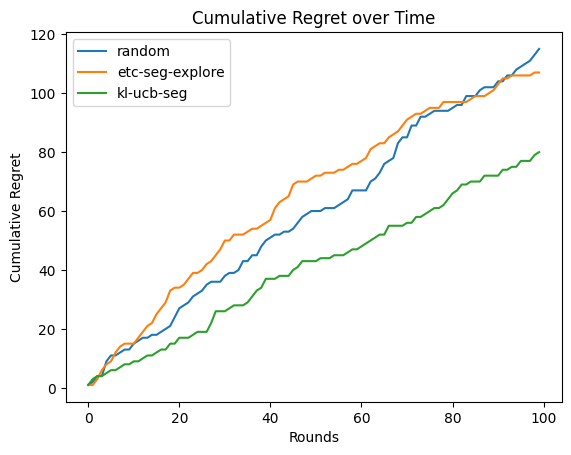

In [ ]:
run_simulation(num=[70000,100], n_rounds=100, n_users_per_round=1000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster])

len policies 3


  1%|          | 1/100 [00:00<00:46,  2.14it/s]

Round: 1/100. Elapsed time: 0.471038 sec.
Cumulative regrets: 
	random : 8.9999994637692
	etc-seg-explore : 15.9999994637692
	kl-ucb-seg : 10.9999994637692 



 10%|█         | 10/100 [00:05<00:46,  1.94it/s]

Round: 10/100. Elapsed time: 5.056609 sec.
Cumulative regrets: 
	random : 119.9999949366902
	etc-seg-explore : 112.9999949366902
	kl-ucb-seg : 107.9999949366902 



 20%|██        | 20/100 [00:10<00:40,  1.95it/s]

Round: 20/100. Elapsed time: 10.227457 sec.
Cumulative regrets: 
	random : 238.99998780319584
	etc-seg-explore : 226.99998780319584
	kl-ucb-seg : 255.99998780319584 



 30%|███       | 30/100 [00:15<00:34,  2.01it/s]

Round: 30/100. Elapsed time: 15.205172 sec.
Cumulative regrets: 
	random : 348.99998289253745
	etc-seg-explore : 288.99998289253745
	kl-ucb-seg : 335.99998289253745 



 40%|████      | 40/100 [00:20<00:32,  1.83it/s]

Round: 40/100. Elapsed time: 20.475106 sec.
Cumulative regrets: 
	random : 434.9999763090709
	etc-seg-explore : 310.9999763090709
	kl-ucb-seg : 408.9999763090709 



 50%|█████     | 50/100 [00:25<00:27,  1.84it/s]

Round: 50/100. Elapsed time: 25.956944 sec.
Cumulative regrets: 
	random : 560.9999691004978
	etc-seg-explore : 324.99996910049776
	kl-ucb-seg : 443.99996910049776 



 60%|██████    | 60/100 [00:30<00:19,  2.10it/s]

Round: 60/100. Elapsed time: 30.746392 sec.
Cumulative regrets: 
	random : 678.9999636592092
	etc-seg-explore : 343.99996365920924
	kl-ucb-seg : 475.99996365920924 



 70%|███████   | 70/100 [00:35<00:14,  2.08it/s]

Round: 70/100. Elapsed time: 35.528020 sec.
Cumulative regrets: 
	random : 789.9999570429336
	etc-seg-explore : 350.9999570429336
	kl-ucb-seg : 501.9999570429336 



 80%|████████  | 80/100 [00:40<00:09,  2.01it/s]

Round: 80/100. Elapsed time: 40.496438 sec.
Cumulative regrets: 
	random : 927.9999510117486
	etc-seg-explore : 353.99995101174864
	kl-ucb-seg : 519.9999510117486 



 90%|█████████ | 90/100 [00:45<00:05,  1.91it/s]

Round: 90/100. Elapsed time: 45.686486 sec.
Cumulative regrets: 
	random : 1042.99994451953
	etc-seg-explore : 361.9999445195299
	kl-ucb-seg : 531.9999445195299 



100%|██████████| 100/100 [00:50<00:00,  1.97it/s]

Round: 100/100. Elapsed time: 50.782385 sec.
Cumulative regrets: 
	random : 1155.9999386939562
	etc-seg-explore : 368.9999386939562
	kl-ucb-seg : 545.9999386939562 

Saving cumulative regrets in results.json


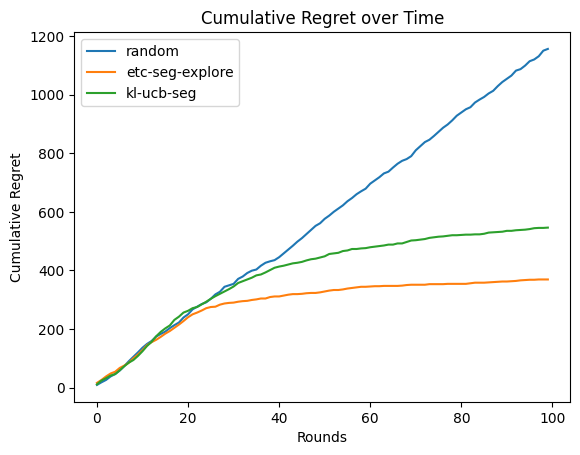

In [ ]:
run_simulation(num=[70000,100], n_rounds=100, n_users_per_round=10000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster])

len policies 3


  1%|          | 1/100 [00:00<01:01,  1.62it/s]

Round: 1/100. Elapsed time: 0.622064 sec.
Cumulative regrets: 
	random : 23.999998649338522
	etc-seg-explore : 18.999998649338522
	kl-ucb-seg : 14.999998649338522 



 10%|█         | 10/100 [00:07<01:06,  1.36it/s]

Round: 10/100. Elapsed time: 7.713197 sec.
Cumulative regrets: 
	random : 172.9999896357167
	etc-seg-explore : 191.9999896357167
	kl-ucb-seg : 154.9999896357167 



 20%|██        | 20/100 [00:14<00:56,  1.42it/s]

Round: 20/100. Elapsed time: 14.949466 sec.
Cumulative regrets: 
	random : 353.99998174975735
	etc-seg-explore : 341.99998174975735
	kl-ucb-seg : 296.99998174975735 



 30%|███       | 30/100 [00:21<00:48,  1.45it/s]

Round: 30/100. Elapsed time: 21.790501 sec.
Cumulative regrets: 
	random : 507.9999720887499
	etc-seg-explore : 414.9999720887499
	kl-ucb-seg : 399.9999720887499 



 40%|████      | 40/100 [00:28<00:41,  1.44it/s]

Round: 40/100. Elapsed time: 28.724698 sec.
Cumulative regrets: 
	random : 671.9999629756512
	etc-seg-explore : 438.9999629756512
	kl-ucb-seg : 509.9999629756512 



 50%|█████     | 50/100 [00:35<00:33,  1.51it/s]

Round: 50/100. Elapsed time: 35.439471 sec.
Cumulative regrets: 
	random : 851.9999539057972
	etc-seg-explore : 463.99995390579716
	kl-ucb-seg : 565.9999539057972 



 60%|██████    | 60/100 [00:42<00:26,  1.49it/s]

Round: 60/100. Elapsed time: 42.183147 sec.
Cumulative regrets: 
	random : 1023.9999427477887
	etc-seg-explore : 487.99994274778874
	kl-ucb-seg : 594.9999427477887 



 70%|███████   | 70/100 [00:48<00:20,  1.49it/s]

Round: 70/100. Elapsed time: 48.868066 sec.
Cumulative regrets: 
	random : 1212.9999331859763
	etc-seg-explore : 504.99993318597626
	kl-ucb-seg : 624.9999331859763 



 80%|████████  | 80/100 [00:55<00:13,  1.51it/s]

Round: 80/100. Elapsed time: 55.479104 sec.
Cumulative regrets: 
	random : 1399.9999210131318
	etc-seg-explore : 520.9999210131318
	kl-ucb-seg : 647.9999210131318 



 90%|█████████ | 90/100 [01:02<00:06,  1.50it/s]

Round: 90/100. Elapsed time: 62.148966 sec.
Cumulative regrets: 
	random : 1567.9999133346973
	etc-seg-explore : 531.9999133346973
	kl-ucb-seg : 672.9999133346973 



100%|██████████| 100/100 [01:08<00:00,  1.46it/s]

Round: 100/100. Elapsed time: 68.727330 sec.
Cumulative regrets: 
	random : 1745.9999036270856
	etc-seg-explore : 548.9999036270856
	kl-ucb-seg : 685.9999036270856 

Saving cumulative regrets in results.json


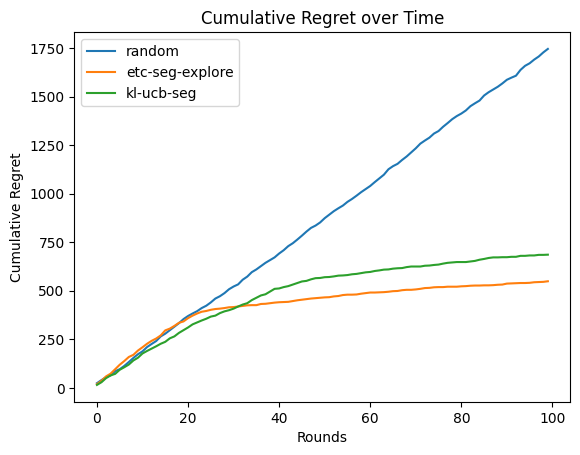

In [ ]:
run_simulation(num=[70000,100], n_rounds=100, n_users_per_round=15000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster])

len policies 10


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
<ipython-input-139-afebf05e8ed5>:47: RuntimeWarning: overflow encountered in exp
  P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
  1%|          | 1/100 [00:20<33:54, 20.55s/it]

Round: 1/100. Elapsed time: 20.549286 sec.
Cumulative regrets: 
	random : 12.999999485426088
	etc-seg-explore : 16.999999485426088
	kl-ucb-seg : 10.999999485426088
	etc-seg-exploit : 9.999999485426088
	epsilon-greedy-explore : 11.999999485426088
	epsilon-greedy-exploit : 9.999999485426088
	ts-seg-naive : 0.9999994854260876
	ts-seg-pessimistic : 11.999999485426088
	ts-lin-naive : 10.999999485426088
	ts-lin-pessimistic : 18.999999485426088 



<ipython-input-139-afebf05e8ed5>:32: RuntimeWarning: overflow encountered in exp
  return 0.5 * (self.q[:-1] * (w[:-1] - self.m[:-1])).dot(w[:-1] - self.m[:-1]) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
 10%|█         | 10/100 [02:48<24:42, 16.48s/it]

Round: 10/100. Elapsed time: 168.348338 sec.
Cumulative regrets: 
	random : 107.9999935269152
	etc-seg-explore : 122.9999935269152
	kl-ucb-seg : 107.9999935269152
	etc-seg-exploit : 96.9999935269152
	epsilon-greedy-explore : 82.9999935269152
	epsilon-greedy-exploit : 56.999993526915205
	ts-seg-naive : 61.999993526915205
	ts-seg-pessimistic : 87.9999935269152
	ts-lin-naive : 10.999993526915205
	ts-lin-pessimistic : 18.999993526915205 



 20%|██        | 20/100 [05:30<21:27, 16.10s/it]

Round: 20/100. Elapsed time: 330.863683 sec.
Cumulative regrets: 
	random : 216.9999869814692
	etc-seg-explore : 251.9999869814692
	kl-ucb-seg : 245.9999869814692
	etc-seg-exploit : 143.9999869814692
	epsilon-greedy-explore : 104.99998698146919
	epsilon-greedy-exploit : 85.99998698146919
	ts-seg-naive : 99.99998698146919
	ts-seg-pessimistic : 160.9999869814692
	ts-lin-naive : 10.999986981469192
	ts-lin-pessimistic : 18.999986981469192 



 30%|███       | 30/100 [08:11<18:34, 15.91s/it]

Round: 30/100. Elapsed time: 491.203456 sec.
Cumulative regrets: 
	random : 339.99998071019945
	etc-seg-explore : 290.99998071019945
	kl-ucb-seg : 321.99998071019945
	etc-seg-exploit : 165.99998071019945
	epsilon-greedy-explore : 126.99998071019945
	epsilon-greedy-exploit : 100.99998071019945
	ts-seg-naive : 123.99998071019945
	ts-seg-pessimistic : 237.99998071019945
	ts-lin-naive : 10.999980710199452
	ts-lin-pessimistic : 18.999980710199452 



 40%|████      | 40/100 [10:49<15:41, 15.69s/it]

Round: 40/100. Elapsed time: 649.467701 sec.
Cumulative regrets: 
	random : 451.9999740492349
	etc-seg-explore : 308.9999740492349
	kl-ucb-seg : 364.9999740492349
	etc-seg-exploit : 177.99997404923488
	epsilon-greedy-explore : 142.99997404923488
	epsilon-greedy-exploit : 117.99997404923488
	ts-seg-naive : 136.99997404923488
	ts-seg-pessimistic : 300.9999740492349
	ts-lin-naive : 10.99997404923488
	ts-lin-pessimistic : 18.99997404923488 



 50%|█████     | 50/100 [13:28<13:23, 16.08s/it]

Round: 50/100. Elapsed time: 808.759535 sec.
Cumulative regrets: 
	random : 566.999969174567
	etc-seg-explore : 332.999969174567
	kl-ucb-seg : 401.999969174567
	etc-seg-exploit : 194.999969174567
	epsilon-greedy-explore : 172.999969174567
	epsilon-greedy-exploit : 133.999969174567
	ts-seg-naive : 142.999969174567
	ts-seg-pessimistic : 353.999969174567
	ts-lin-naive : 10.999969174567013
	ts-lin-pessimistic : 18.999969174567013 



 60%|██████    | 60/100 [16:08<10:38, 15.97s/it]

Round: 60/100. Elapsed time: 968.730928 sec.
Cumulative regrets: 
	random : 672.9999623950553
	etc-seg-explore : 347.99996239505526
	kl-ucb-seg : 449.99996239505526
	etc-seg-exploit : 219.99996239505526
	epsilon-greedy-explore : 188.99996239505526
	epsilon-greedy-exploit : 146.99996239505526
	ts-seg-naive : 155.99996239505526
	ts-seg-pessimistic : 405.99996239505526
	ts-lin-naive : 10.999962395055263
	ts-lin-pessimistic : 18.999962395055263 



 70%|███████   | 70/100 [18:49<08:04, 16.16s/it]

Round: 70/100. Elapsed time: 1129.996703 sec.
Cumulative regrets: 
	random : 771.9999581360044
	etc-seg-explore : 355.99995813600435
	kl-ucb-seg : 486.99995813600435
	etc-seg-exploit : 229.99995813600435
	epsilon-greedy-explore : 198.99995813600435
	epsilon-greedy-exploit : 165.99995813600435
	ts-seg-naive : 164.99995813600435
	ts-seg-pessimistic : 475.99995813600435
	ts-lin-naive : 10.999958136004352
	ts-lin-pessimistic : 18.999958136004352 



 80%|████████  | 80/100 [21:28<05:16, 15.84s/it]

Round: 80/100. Elapsed time: 1288.870936 sec.
Cumulative regrets: 
	random : 898.9999524446193
	etc-seg-explore : 370.99995244461934
	kl-ucb-seg : 500.99995244461934
	etc-seg-exploit : 243.99995244461934
	epsilon-greedy-explore : 210.99995244461934
	epsilon-greedy-exploit : 185.99995244461934
	ts-seg-naive : 171.99995244461934
	ts-seg-pessimistic : 520.9999524446193
	ts-lin-naive : 10.999952444619339
	ts-lin-pessimistic : 18.99995244461934 



 90%|█████████ | 90/100 [24:07<02:39, 15.98s/it]

Round: 90/100. Elapsed time: 1447.811557 sec.
Cumulative regrets: 
	random : 999.9999462826436
	etc-seg-explore : 380.9999462826436
	kl-ucb-seg : 511.9999462826436
	etc-seg-exploit : 258.9999462826436
	epsilon-greedy-explore : 232.99994628264358
	epsilon-greedy-exploit : 199.99994628264358
	ts-seg-naive : 177.99994628264358
	ts-seg-pessimistic : 565.9999462826436
	ts-lin-naive : 10.999946282643577
	ts-lin-pessimistic : 18.999946282643577 



100%|██████████| 100/100 [26:46<00:00, 16.06s/it]

Round: 100/100. Elapsed time: 1606.343921 sec.
Cumulative regrets: 
	random : 1113.999938337589
	etc-seg-explore : 382.9999383375889
	kl-ucb-seg : 521.9999383375889
	etc-seg-exploit : 270.9999383375889
	epsilon-greedy-explore : 246.9999383375889
	epsilon-greedy-exploit : 213.9999383375889
	ts-seg-naive : 184.9999383375889
	ts-seg-pessimistic : 614.9999383375889
	ts-lin-naive : 10.999938337588901
	ts-lin-pessimistic : 18.9999383375889 

Saving cumulative regrets in results.json


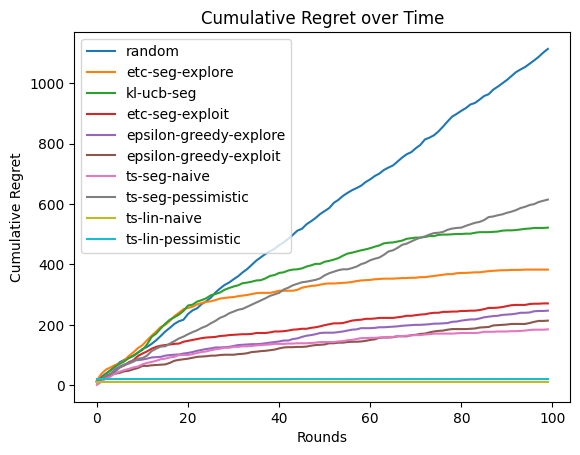

In [ ]:
run_simulation(num=[70000,100], n_rounds=100, n_users_per_round=10000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster])

len policies 11


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
<ipython-input-139-afebf05e8ed5>:32: RuntimeWarning: overflow encountered in exp
  return 0.5 * (self.q[:-1] * (w[:-1] - self.m[:-1])).dot(w[:-1] - self.m[:-1]) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
  1%|          | 1/100 [00:20<33:59, 20.60s/it]

Round: 1/100. Elapsed time: 20.607880 sec.
Cumulative regrets: 
	random : 17.999998910821887
	etc-seg-explore : 10.999998910821887
	kl-ucb-seg : 6.999998910821887
	etc-seg-exploit : 3.999998910821887
	epsilon-greedy-explore : 5.999998910821887
	epsilon-greedy-exploit : 7.999998910821887
	ts-seg-naive : 6.999998910821887
	ts-seg-pessimistic : 12.999998910821887
	ts-lin-naive : 12.999998910821887
	ts-lin-pessimistic : 7.999998910821887
	most-popular : 16.999998910821887 



 10%|█         | 10/100 [02:53<25:18, 16.87s/it]

Round: 10/100. Elapsed time: 173.176932 sec.
Cumulative regrets: 
	random : 144.99999308341285
	etc-seg-explore : 124.99999308341285
	kl-ucb-seg : 98.99999308341285
	etc-seg-exploit : 94.99999308341285
	epsilon-greedy-explore : 67.99999308341285
	epsilon-greedy-exploit : 49.999993083412846
	ts-seg-naive : 60.999993083412846
	ts-seg-pessimistic : 85.99999308341285
	ts-lin-naive : 12.999993083412846
	ts-lin-pessimistic : 7.999993083412846
	most-popular : 131.99999308341285 



 20%|██        | 20/100 [05:41<22:38, 16.98s/it]

Round: 20/100. Elapsed time: 341.081502 sec.
Cumulative regrets: 
	random : 256.9999869991261
	etc-seg-explore : 228.99998699912612
	kl-ucb-seg : 194.99998699912612
	etc-seg-exploit : 133.99998699912612
	epsilon-greedy-explore : 97.99998699912612
	epsilon-greedy-exploit : 70.99998699912612
	ts-seg-naive : 88.99998699912612
	ts-seg-pessimistic : 182.99998699912612
	ts-lin-naive : 12.999986999126122
	ts-lin-pessimistic : 7.999986999126122
	most-popular : 269.9999869991261 



 30%|███       | 30/100 [08:32<19:53, 17.06s/it]

Round: 30/100. Elapsed time: 512.130857 sec.
Cumulative regrets: 
	random : 360.9999800679507
	etc-seg-explore : 297.9999800679507
	kl-ucb-seg : 278.9999800679507
	etc-seg-exploit : 157.99998006795067
	epsilon-greedy-explore : 124.99998006795067
	epsilon-greedy-exploit : 87.99998006795067
	ts-seg-naive : 100.99998006795067
	ts-seg-pessimistic : 250.99998006795067
	ts-lin-naive : 12.999980067950673
	ts-lin-pessimistic : 7.999980067950673
	most-popular : 407.9999800679507 



 40%|████      | 40/100 [11:23<17:01, 17.02s/it]

Round: 40/100. Elapsed time: 683.639177 sec.
Cumulative regrets: 
	random : 485.99997403148154
	etc-seg-explore : 314.99997403148154
	kl-ucb-seg : 336.99997403148154
	etc-seg-exploit : 172.99997403148154
	epsilon-greedy-explore : 142.99997403148154
	epsilon-greedy-exploit : 100.99997403148154
	ts-seg-naive : 108.99997403148154
	ts-seg-pessimistic : 320.99997403148154
	ts-lin-naive : 12.999974031481543
	ts-lin-pessimistic : 7.999974031481543
	most-popular : 547.9999740314815 



 50%|█████     | 50/100 [14:13<14:05, 16.90s/it]

Round: 50/100. Elapsed time: 853.475603 sec.
Cumulative regrets: 
	random : 589.9999693385107
	etc-seg-explore : 327.9999693385107
	kl-ucb-seg : 389.9999693385107
	etc-seg-exploit : 188.9999693385107
	epsilon-greedy-explore : 164.9999693385107
	epsilon-greedy-exploit : 119.99996933851071
	ts-seg-naive : 114.99996933851071
	ts-seg-pessimistic : 394.9999693385107
	ts-lin-naive : 12.99996933851071
	ts-lin-pessimistic : 7.999969338510709
	most-popular : 706.9999693385107 



 60%|██████    | 60/100 [17:00<11:10, 16.76s/it]

Round: 60/100. Elapsed time: 1020.827222 sec.
Cumulative regrets: 
	random : 701.9999623835356
	etc-seg-explore : 336.9999623835356
	kl-ucb-seg : 430.9999623835356
	etc-seg-exploit : 198.9999623835356
	epsilon-greedy-explore : 185.9999623835356
	epsilon-greedy-exploit : 136.9999623835356
	ts-seg-naive : 124.9999623835356
	ts-seg-pessimistic : 459.9999623835356
	ts-lin-naive : 12.999962383535603
	ts-lin-pessimistic : 7.999962383535603
	most-popular : 840.9999623835356 



 70%|███████   | 70/100 [19:47<08:19, 16.64s/it]

Round: 70/100. Elapsed time: 1187.779509 sec.
Cumulative regrets: 
	random : 816.9999573975292
	etc-seg-explore : 343.9999573975292
	kl-ucb-seg : 463.9999573975292
	etc-seg-exploit : 206.99995739752922
	epsilon-greedy-explore : 205.99995739752922
	epsilon-greedy-exploit : 148.99995739752922
	ts-seg-naive : 131.99995739752922
	ts-seg-pessimistic : 529.9999573975292
	ts-lin-naive : 12.999957397529215
	ts-lin-pessimistic : 7.999957397529215
	most-popular : 985.9999573975292 



 80%|████████  | 80/100 [22:33<05:32, 16.62s/it]

Round: 80/100. Elapsed time: 1353.675138 sec.
Cumulative regrets: 
	random : 949.9999517509896
	etc-seg-explore : 354.99995175098957
	kl-ucb-seg : 483.99995175098957
	etc-seg-exploit : 219.99995175098957
	epsilon-greedy-explore : 222.99995175098957
	epsilon-greedy-exploit : 162.99995175098957
	ts-seg-naive : 139.99995175098957
	ts-seg-pessimistic : 588.9999517509896
	ts-lin-naive : 12.999951750989567
	ts-lin-pessimistic : 7.999951750989567
	most-popular : 1136.9999517509896 



 90%|█████████ | 90/100 [25:19<02:45, 16.51s/it]

Round: 90/100. Elapsed time: 1519.388039 sec.
Cumulative regrets: 
	random : 1084.9999461346615
	etc-seg-explore : 364.9999461346615
	kl-ucb-seg : 489.9999461346615
	etc-seg-exploit : 229.9999461346615
	epsilon-greedy-explore : 240.9999461346615
	epsilon-greedy-exploit : 173.9999461346615
	ts-seg-naive : 152.9999461346615
	ts-seg-pessimistic : 650.9999461346615
	ts-lin-naive : 12.999946134661513
	ts-lin-pessimistic : 7.9999461346615135
	most-popular : 1297.9999461346615 



100%|██████████| 100/100 [28:03<00:00, 16.84s/it]

Round: 100/100. Elapsed time: 1683.743150 sec.
Cumulative regrets: 
	random : 1189.9999399658354
	etc-seg-explore : 370.99993996583544
	kl-ucb-seg : 497.99993996583544
	etc-seg-exploit : 241.99993996583544
	epsilon-greedy-explore : 257.99993996583544
	epsilon-greedy-exploit : 188.99993996583544
	ts-seg-naive : 153.99993996583544
	ts-seg-pessimistic : 719.9999399658354
	ts-lin-naive : 12.999939965835438
	ts-lin-pessimistic : 7.999939965835438
	most-popular : 1456.9999399658354 

Saving cumulative regrets in results.json


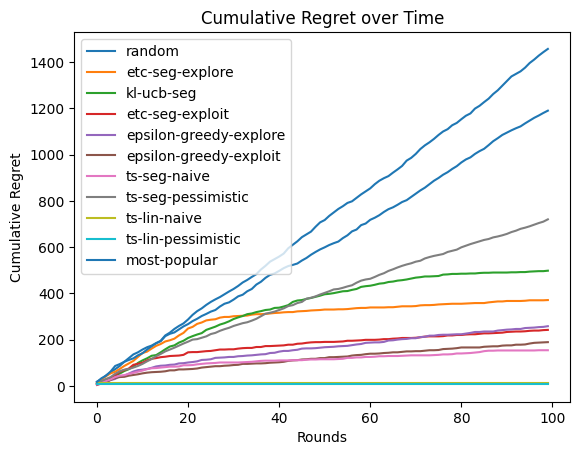

In [ ]:
run_simulation(num=[70000,100], n_rounds=100, n_users_per_round=10000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster])

In [ ]:
def run_simulation_extra_metrics(num, n_rounds, n_users_per_round, print_every, svd_, user_history):
    # Variables de configuración
    output_path = "results.json"
    policies = "random,etc-seg-explore,kl-ucb-seg,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic,most-popular"
    n_recos = 12
    l_init = 3
    user_features_svd, playlist_features_svd = svd_
    num_users, num_playlist = num

    # Cargar datos
    user_segment_num = user_embeddings["cluster"][0:num_users].to_numpy()
    len_sample = num_users
    user_features_ = np.concatenate([user_features_svd, np.ones((len_sample, 1))], axis=1)

    # Convert user_features_svd to DataFrame if it's a NumPy array
    if isinstance(user_features_svd, np.ndarray):
        user_features_svd = pd.DataFrame(user_features_svd)

    user_features_svd_num = user_features_svd.head(num_users).to_numpy()
    users_ids = user_features_svd.head(num_users).index.to_list()

    # Convert playlist_features_svd to DataFrame if it's a NumPy array
    if isinstance(playlist_features_svd, np.ndarray):
        playlist_features_svd = pd.DataFrame(playlist_features_svd)

    playlist_features_svd_num = playlist_features_svd.head(num_playlist).to_numpy()
    cont_env = ContextualEnvironment(user_features_svd_num, playlist_features_svd_num, user_segment_num, n_recos)

    # Configuración del entorno y políticas
    n_playlist = num_playlist
    n_users = num_users
    policies_name = policies.split(",")
    policies = set_policies(policies_name, user_segment_num, user_features_svd_num, n_playlist)
    n_policies = len(policies)
    overall_rewards = np.zeros((n_policies, n_rounds))
    overall_optimal_reward = np.zeros(n_rounds)

    # Almacenar métricas adicionales
    diversity_metrics = {policy: [] for policy in policies_name}
    novelty_metrics = {policy: [] for policy in policies_name}
    mrr_metrics = {policy: [] for policy in policies_name}
    ndcg_metrics = {policy: [] for policy in policies_name}

    # Simulaciones
    start_time = time.time()
    mem_info_before = psutil.virtual_memory().used
    cpu_usage_before = psutil.cpu_percent(interval=None)
    for i in tqdm(range(n_rounds)):
        user_ids = np.random.choice(range(n_users), n_users_per_round, replace=False)
        overall_optimal_reward[i] = np.take(cont_env.th_rewards, user_ids).sum()
        for j in range(n_policies):
            recos = policies[j].recommend_to_users_batch(user_ids, n_recos, l_init)
            rewards = cont_env.simulate_batch_users_reward(batch_user_ids=user_ids, batch_recos=recos)
            policies[j].update_policy(user_ids, recos, rewards, l_init)
            # Guardar recompensas
            overall_rewards[j, i] = rewards.sum()

            # Calcular métricas adicionales
            diversity_metrics[policies_name[j]].append(cont_env.compute_diversity(recos))
            novelty_metrics[policies_name[j]].append(cont_env.compute_novelty(recos, user_ids, user_history))
            mrr_metrics[policies_name[j]].append(cont_env.compute_mrr(recos, user_ids))
            ndcg_metrics[policies_name[j]].append(cont_env.compute_ndcg(recos, user_ids))

        if i == 0 or (i + 1) % print_every == 0 or i + 1 == n_rounds:
            mem_info_after = psutil.virtual_memory().used
            memory_used = (mem_info_after - mem_info_before) / (1024 ** 2)  # Convertir a MB
            cpu_usage_after = psutil.cpu_percent(interval=None)
            print(
                  f"Round: {i + 1}/{n_rounds}. Elapsed time: {time.time() - start_time:.2f} sec. "
                  f"Memory used: {memory_used} MB. CPU used: {cpu_usage_after - cpu_usage_before}%")
            print("Round: %d/%d. Elapsed time: %f sec." % (i + 1, n_rounds, time.time() - start_time))
            print("Cumulative regrets: \n%s \n" % "\n".join([
                f"{policies_name[j]} : {np.sum(overall_optimal_reward - overall_rewards[j])}" for j in range(n_policies)
            ]))

            # Imprimir métricas adicionales
            for j in range(n_policies):
                print(f"Policy: {policies_name[j]}")
                print(f"  Diversity: {np.mean(diversity_metrics[policies_name[j]])}")
                print(f"  Novelty: {np.mean(novelty_metrics[policies_name[j]])}")
                print(f"  MRR: {np.mean(mrr_metrics[policies_name[j]])}")
                print(f"  NDCG: {np.mean(ndcg_metrics[policies_name[j]])}")

    # Guardar resultados
    print("Saving cumulative regrets in %s" % output_path)
    cumulative_regrets = {policies_name[j]: list(np.cumsum(overall_optimal_reward - overall_rewards[j])) for j in range(n_policies)}
    diversity_metrics = {policies_name[j]: diversity_metrics[policies_name[j]] for j in range(n_policies)}
    novelty_metrics = {policies_name[j]: novelty_metrics[policies_name[j]] for j in range(n_policies)}
    mrr_metrics = {policies_name[j]: mrr_metrics[policies_name[j]] for j in range(n_policies)}
    ndcg_metrics = {policies_name[j]: ndcg_metrics[policies_name[j]] for j in range(n_policies)}

    # Graficar resultados
    for j in range(n_policies):
        if policies_name[j] == "random":
            plt.plot(cumulative_regrets[policies_name[j]], label=policies_name[j], ls="--")
        else:
          plt.plot(cumulative_regrets[policies_name[j]], label=policies_name[j])
    plt.title('Cumulative Regret over Time')
    plt.xlabel('Rounds')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    plt.show()
    return cumulative_regrets, diversity_metrics, novelty_metrics, mrr_metrics, ndcg_metrics


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
<ipython-input-139-afebf05e8ed5>:47: RuntimeWarning: overflow encountered in exp
  P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
  1%|          | 1/100 [00:59<1:38:38, 59.79s/it]

Round: 1/100. Elapsed time: 59.77 sec. Memory used: 107.69140625 MB. CPU used: 20.700000000000003%
Round: 1/100. Elapsed time: 59.772858 sec.
Cumulative regrets: 
random : 7.999999781000952
etc-seg-explore : 11.999999781000952
kl-ucb-seg : 12.999999781000952
etc-seg-exploit : 10.999999781000952
epsilon-greedy-explore : 14.999999781000952
epsilon-greedy-exploit : 5.999999781000952
ts-seg-naive : 11.999999781000952
ts-seg-pessimistic : 12.999999781000952
ts-lin-naive : 16.99999978100095
ts-lin-pessimistic : 14.999999781000952
most-popular : 8.999999781000952 

Policy: random
  Diversity: 0.9530455999591148
  Novelty: 0.9225083333333333
  MRR: 0.2348523881673882
  NDCG: 0.09782781640989563
Policy: etc-seg-explore
  Diversity: 0.9528606447368022
  Novelty: 0.9205166666666666
  MRR: 0.23834141414141413
  NDCG: 0.09845809029982903
Policy: kl-ucb-seg
  Diversity: 0.953001104232909
  Novelty: 0.9215666666666666
  MRR: 0.23239060966810968
  NDCG: 0.096577274182895
Policy: etc-seg-exploit
  Dive

<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
<ipython-input-139-afebf05e8ed5>:32: RuntimeWarning: overflow encountered in exp
  return 0.5 * (self.q[:-1] * (w[:-1] - self.m[:-1])).dot(w[:-1] - self.m[:-1]) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
<ipython-input-139-afebf05e8ed5>:32: RuntimeWarning: overflow encountered in exp
  return 0.5 * (self.q[:-1] * (w[:-1] - self.m[:-1])).dot(w[:-1] - self.m[:-1]) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j

Round: 10/100. Elapsed time: 557.24 sec. Memory used: 555.328125 MB. CPU used: 13.799999999999999%
Round: 10/100. Elapsed time: 557.237053 sec.
Cumulative regrets: 
random : 124.99999489038419
etc-seg-explore : 116.99999489038419
kl-ucb-seg : 107.99999489038419
etc-seg-exploit : 100.99999489038419
epsilon-greedy-explore : 70.99999489038419
epsilon-greedy-exploit : 59.99999489038419
ts-seg-naive : 89.99999489038419
ts-seg-pessimistic : 72.99999489038419
ts-lin-naive : 17.999994890384187
ts-lin-pessimistic : 14.999994890384187
most-popular : 53.99999489038419 

Policy: random
  Diversity: 0.952972507594448
  Novelty: 0.9219458333333335
  MRR: 0.2362112294372294
  NDCG: 0.09819554961275488
Policy: etc-seg-explore
  Diversity: 0.9523821480099478
  Novelty: 0.9216416666666666
  MRR: 0.23679444119769122
  NDCG: 0.09846920884784623
Policy: kl-ucb-seg
  Diversity: 0.9540080154168935
  Novelty: 0.9219191666666667
  MRR: 0.23555738131313134
  NDCG: 0.09795414574212859
Policy: etc-seg-exploit
  D

<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 11%|█         | 11/100 [10:11<1:21:52, 55.20s/it]<ipython-input-139-afebf05e8ed5>:32: RuntimeWarning: overflow encountered in exp
  return 0.5 * (self.q[:-1] * (w[:-1] - self.m[:-1])).dot(w[:-1] - self.m[:-1]) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 12%|█▏        | 12/100 [11:06<1:20:38, 54.98s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1

Round: 20/100. Elapsed time: 1107.65 sec. Memory used: 750.4140625 MB. CPU used: 13.6%
Round: 20/100. Elapsed time: 1107.651658 sec.
Cumulative regrets: 
random : 243.99999050075348
etc-seg-explore : 220.99999050075348
kl-ucb-seg : 196.99999050075348
etc-seg-exploit : 140.99999050075348
epsilon-greedy-explore : 114.99999050075348
epsilon-greedy-exploit : 87.99999050075348
ts-seg-naive : 131.99999050075348
ts-seg-pessimistic : 123.99999050075348
ts-lin-naive : 17.999990500753484
ts-lin-pessimistic : 14.999990500753484
most-popular : 88.99999050075348 

Policy: random
  Diversity: 0.9529165993187416
  Novelty: 0.9215670833333335
  MRR: 0.2357301219336219
  NDCG: 0.09804128495693779
Policy: etc-seg-explore
  Diversity: 0.9525029166701766
  Novelty: 0.9210141666666665
  MRR: 0.23716402886002885
  NDCG: 0.09842658819729065
Policy: kl-ucb-seg
  Diversity: 0.9551877129696054
  Novelty: 0.9218120833333334
  MRR: 0.23694767550505053
  NDCG: 0.09835468351269683
Policy: etc-seg-exploit
  Diversit

 22%|██▏       | 22/100 [20:19<1:12:06, 55.46s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 30%|███       | 30/100 [27:39<1:03:51, 54.73s/it]

Round: 30/100. Elapsed time: 1659.10 sec. Memory used: 848.30859375 MB. CPU used: 13.200000000000001%
Round: 30/100. Elapsed time: 1659.099224 sec.
Cumulative regrets: 
random : 348.99998547616815
etc-seg-explore : 281.99998547616815
kl-ucb-seg : 298.99998547616815
etc-seg-exploit : 154.99998547616815
epsilon-greedy-explore : 144.99998547616815
epsilon-greedy-exploit : 111.99998547616815
ts-seg-naive : 151.99998547616815
ts-seg-pessimistic : 168.99998547616815
ts-lin-naive : 17.99998547616815
ts-lin-pessimistic : 14.999985476168149
most-popular : 141.99998547616815 

Policy: random
  Diversity: 0.952867581209132
  Novelty: 0.9214905555555558
  MRR: 0.23583296741221746
  NDCG: 0.09803485214541882
Policy: etc-seg-explore
  Diversity: 0.9558289184194462
  Novelty: 0.9205669444444442
  MRR: 0.23702793049543047
  NDCG: 0.09846991526395309
Policy: kl-ucb-seg
  Diversity: 0.9572007001135628
  Novelty: 0.9214188888888889
  MRR: 0.23691880351130346
  NDCG: 0.09837175706345368
Policy: etc-seg-ex

 32%|███▏      | 32/100 [29:30<1:02:40, 55.31s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 35%|███▌      | 35/100 [32:15<59:38, 55.05s/it]  <ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 37%|███▋      | 37/100 [34:06<58:10, 55.41s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 39%|███▉      | 39/100 [35:58<56:34

Round: 40/100. Elapsed time: 2212.72 sec. Memory used: 918.875 MB. CPU used: 13.1%
Round: 40/100. Elapsed time: 2212.723210 sec.
Cumulative regrets: 
random : 480.9999813849754
etc-seg-explore : 315.9999813849754
kl-ucb-seg : 346.9999813849754
etc-seg-exploit : 167.9999813849754
epsilon-greedy-explore : 165.9999813849754
epsilon-greedy-exploit : 134.9999813849754
ts-seg-naive : 160.9999813849754
ts-seg-pessimistic : 214.9999813849754
ts-lin-naive : 17.9999813849754
ts-lin-pessimistic : 14.9999813849754
most-popular : 184.9999813849754 

Policy: random
  Diversity: 0.9529101187685828
  Novelty: 0.92140125
  MRR: 0.23592574431818183
  NDCG: 0.0980760469097741
Policy: etc-seg-explore
  Diversity: 0.9595916225847545
  Novelty: 0.920556458333333
  MRR: 0.23732894868326126
  NDCG: 0.09862271640555802
Policy: kl-ucb-seg
  Diversity: 0.9598277351480583
  Novelty: 0.9211904166666667
  MRR: 0.23667417045454542
  NDCG: 0.09836211978140835
Policy: etc-seg-exploit
  Diversity: 0.9740949185337628
  

 41%|████      | 41/100 [37:47<54:07, 55.04s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 47%|████▋     | 47/100 [43:14<48:12, 54.57s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 50%|█████     | 50/100 [45:59<45:41, 54.83s/it]

Round: 50/100. Elapsed time: 2759.28 sec. Memory used: 949.08984375 MB. CPU used: 12.9%
Round: 50/100. Elapsed time: 2759.282163 sec.
Cumulative regrets: 
random : 597.999976636127
etc-seg-explore : 345.99997663612703
kl-ucb-seg : 385.99997663612703
etc-seg-exploit : 182.99997663612703
epsilon-greedy-explore : 191.99997663612703
epsilon-greedy-exploit : 146.99997663612703
ts-seg-naive : 169.99997663612703
ts-seg-pessimistic : 263.99997663612703
ts-lin-naive : 17.99997663612703
ts-lin-pessimistic : 14.99997663612703
most-popular : 222.99997663612703 

Policy: random
  Diversity: 0.9529120113017377
  Novelty: 0.9214065000000002
  MRR: 0.2363383336940837
  NDCG: 0.09819937067041198
Policy: etc-seg-explore
  Diversity: 0.9619732851143603
  Novelty: 0.9206346666666664
  MRR: 0.23716917518037517
  NDCG: 0.0986331339804675
Policy: kl-ucb-seg
  Diversity: 0.9612757511831236
  Novelty: 0.9211053333333334
  MRR: 0.2365562676046176
  NDCG: 0.0983872507185875
Policy: etc-seg-exploit
  Diversity: 0

 60%|██████    | 60/100 [55:05<36:27, 54.70s/it]

Round: 60/100. Elapsed time: 3305.20 sec. Memory used: 1015.32421875 MB. CPU used: 12.700000000000001%
Round: 60/100. Elapsed time: 3305.197945 sec.
Cumulative regrets: 
random : 712.9999714167552
etc-seg-explore : 369.9999714167552
kl-ucb-seg : 418.9999714167552
etc-seg-exploit : 195.99997141675522
epsilon-greedy-explore : 211.99997141675522
epsilon-greedy-exploit : 166.99997141675522
ts-seg-naive : 176.99997141675522
ts-seg-pessimistic : 300.9999714167552
ts-lin-naive : 17.999971416755216
ts-lin-pessimistic : 14.999971416755216
most-popular : 259.9999714167552 

Policy: random
  Diversity: 0.95289914872053
  Novelty: 0.921436666666667
  MRR: 0.2361469624218374
  NDCG: 0.09815999190175143
Policy: etc-seg-explore
  Diversity: 0.9642504159537202
  Novelty: 0.9207497222222218
  MRR: 0.2371650557359307
  NDCG: 0.09861489662578002
Policy: kl-ucb-seg
  Diversity: 0.9624375724759436
  Novelty: 0.9210190277777777
  MRR: 0.2365437762746513
  NDCG: 0.0984126574671941
Policy: etc-seg-exploit
  D

 65%|██████▌   | 65/100 [59:40<32:17, 55.37s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 67%|██████▋   | 67/100 [1:01:29<30:10, 54.86s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 70%|███████   | 70/100 [1:04:12<27:18, 54.61s/it]

Round: 70/100. Elapsed time: 3852.51 sec. Memory used: 1056.01171875 MB. CPU used: 12.6%
Round: 70/100. Elapsed time: 3852.513682 sec.
Cumulative regrets: 
random : 823.9999668304372
etc-seg-explore : 390.9999668304372
kl-ucb-seg : 443.9999668304372
etc-seg-exploit : 206.9999668304372
epsilon-greedy-explore : 231.9999668304372
epsilon-greedy-exploit : 176.9999668304372
ts-seg-naive : 184.9999668304372
ts-seg-pessimistic : 345.9999668304372
ts-lin-naive : 17.999966830437188
ts-lin-pessimistic : 14.999966830437188
most-popular : 300.9999668304372 

Policy: random
  Diversity: 0.9529067731485876
  Novelty: 0.9214179761904764
  MRR: 0.23619685214388778
  NDCG: 0.09816285561603451
Policy: etc-seg-explore
  Diversity: 0.9659844339239828
  Novelty: 0.9208441666666665
  MRR: 0.2371699088847659
  NDCG: 0.09862795337813762
Policy: kl-ucb-seg
  Diversity: 0.9629896975126593
  Novelty: 0.9206895238095237
  MRR: 0.23663804128014854
  NDCG: 0.09845583424760253
Policy: etc-seg-exploit
  Diversity: 0.

 74%|███████▍  | 74/100 [1:07:49<23:35, 54.43s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 79%|███████▉  | 79/100 [1:12:22<19:08, 54.70s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 80%|████████  | 80/100 [1:13:18<18:18, 54.91s/it]

Round: 80/100. Elapsed time: 4398.10 sec. Memory used: 1147.359375 MB. CPU used: 12.6%
Round: 80/100. Elapsed time: 4398.095726 sec.
Cumulative regrets: 
random : 946.9999610735431
etc-seg-explore : 406.9999610735431
kl-ucb-seg : 463.9999610735431
etc-seg-exploit : 214.9999610735431
epsilon-greedy-explore : 248.9999610735431
epsilon-greedy-exploit : 187.9999610735431
ts-seg-naive : 192.9999610735431
ts-seg-pessimistic : 378.9999610735431
ts-lin-naive : 17.99996107354309
ts-lin-pessimistic : 14.99996107354309
most-popular : 342.9999610735431 

Policy: random
  Diversity: 0.952916065489869
  Novelty: 0.9214797916666667
  MRR: 0.23614568051046167
  NDCG: 0.09811384859752606
Policy: etc-seg-explore
  Diversity: 0.9673840079326103
  Novelty: 0.9208426041666665
  MRR: 0.2370313806818181
  NDCG: 0.09857036373059176
Policy: kl-ucb-seg
  Diversity: 0.9638486096902601
  Novelty: 0.9204094791666666
  MRR: 0.23651162545093804
  NDCG: 0.09840953332453209
Policy: etc-seg-exploit
  Diversity: 0.97764

 82%|████████▏ | 82/100 [1:15:09<16:36, 55.33s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 85%|████████▌ | 85/100 [1:17:56<13:51, 55.41s/it]<ipython-input-139-afebf05e8ed5>:37: RuntimeWarning: overflow encountered in exp
  return np.concatenate((self.q[:-1] * (w[:-1] - self.m[:-1]),0.0),axis = None) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis = 0)
 90%|█████████ | 90/100 [1:22:34<09:17, 55.74s/it]

Round: 90/100. Elapsed time: 4954.75 sec. Memory used: 1122.57421875 MB. CPU used: 12.6%
Round: 90/100. Elapsed time: 4954.750565 sec.
Cumulative regrets: 
random : 1056.9999549348704
etc-seg-explore : 425.9999549348704
kl-ucb-seg : 480.9999549348704
etc-seg-exploit : 221.9999549348704
epsilon-greedy-explore : 268.9999549348704
epsilon-greedy-exploit : 199.9999549348704
ts-seg-naive : 200.9999549348704
ts-seg-pessimistic : 420.9999549348704
ts-lin-naive : 17.999954934870402
ts-lin-pessimistic : 14.999954934870402
most-popular : 382.9999549348704 

Policy: random
  Diversity: 0.9529047006172716
  Novelty: 0.9214976851851853
  MRR: 0.23616305331088652
  NDCG: 0.09810352143463144
Policy: etc-seg-explore
  Diversity: 0.9684891827389632
  Novelty: 0.920935462962963
  MRR: 0.23705910710277361
  NDCG: 0.09858600512497777
Policy: kl-ucb-seg
  Diversity: 0.9644582182799933
  Novelty: 0.9203910185185185
  MRR: 0.23636493061568073
  NDCG: 0.09841499251165534
Policy: etc-seg-exploit
  Diversity: 0

100%|██████████| 100/100 [1:31:49<00:00, 55.10s/it]

Round: 100/100. Elapsed time: 5509.54 sec. Memory used: 1229.91796875 MB. CPU used: 12.6%
Round: 100/100. Elapsed time: 5509.540950 sec.
Cumulative regrets: 
random : 1188.999950511141
etc-seg-explore : 445.9999505111409
kl-ucb-seg : 496.9999505111409
etc-seg-exploit : 225.99995051114092
epsilon-greedy-explore : 284.9999505111409
epsilon-greedy-exploit : 210.99995051114092
ts-seg-naive : 205.99995051114092
ts-seg-pessimistic : 455.9999505111409
ts-lin-naive : 17.999950511140923
ts-lin-pessimistic : 14.999950511140923
most-popular : 436.9999505111409 

Policy: random
  Diversity: 0.9529071918274226
  Novelty: 0.92147375
  MRR: 0.23608612085137068
  NDCG: 0.09809033765199356
Policy: etc-seg-explore
  Diversity: 0.9692310072701296
  Novelty: 0.9210393333333335
  MRR: 0.2370324024531023
  NDCG: 0.09858292668933846
Policy: kl-ucb-seg
  Diversity: 0.9654168189079195
  Novelty: 0.9203276666666665
  MRR: 0.23649477463924976
  NDCG: 0.09847243158628304
Policy: etc-seg-exploit
  Diversity: 0.978

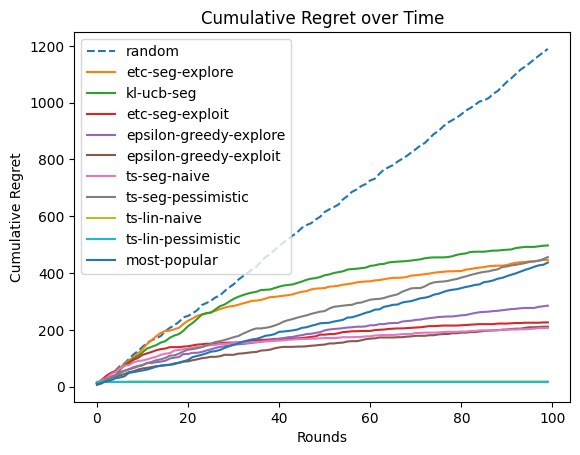

In [ ]:
metrics_run_1 = run_simulation_extra_metrics(num=[70000,100], n_rounds=100, n_users_per_round=10000, print_every=10, svd_=[user_features_svd, playlist_svd_cluster], user_history=user_history_playlists)